In [5]:
import os
import io
from pathlib import Path

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from astropy import units as u
from astropy import table
from astropy.io import votable, fits
from astropy.coordinates import SkyCoord

import pyvo as vo

from tqdm.notebook import tqdm

from multiprocess import Pool

from dill import dump, load

In [6]:
import warnings
from astroquery.exceptions import NoResultsWarning
warnings.simplefilter('ignore', NoResultsWarning)
warnings.simplefilter('ignore', u.UnitsWarning) # comes up in the parsing of some heasarc tables but is just a "discouraged by FITS standard" issue

# Get/make catalogs

First we need to make sure we get the latest satellite data following https://github.com/sagasurvey/internal-data-release/blob/main/README.md#update-data-and-code-do-these-steps-every-time-there-is-a-new-release

In [7]:
import SAGA

from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

saga = SAGA.QuickStart('/Users/etollerud/Dropbox/', '../../sagadata/')

SAGA `shared_dir` set to /Users/etollerud/Dropbox/
SAGA `local_dir`  set to ../../sagadata/


In [8]:
if os.path.exists(saga.database["combined_base"].local.path) and fits.getheader(saga.database["combined_base"].local.path, 1)["VERSION"] == SAGA.__version__:
    print('local base and version match, no download needed')
else:
    print('updating/downloading base catalog')
    if os.path.exists(saga.database["host_stats"].local.path):
        os.remove(saga.database["host_stats"].local.path)
    saga.database["host_stats"].clear_cache()
    
    saga.database["combined_base"].remote.path = "http://web.physics.utah.edu/~yymao/data/tdk7-r8eh-5hf4-cke7/saga_base_v3_all.fits"
    saga.database["combined_base"].download(overwrite=True)

local base and version match, no download needed


In [9]:
hosts = saga.host_catalog.load(include_stats=True)

In [10]:
paper3_hosts = H.paper3.filter(hosts)

In [11]:
paper3_base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
paper3_sats = C.is_sat.filter(paper3_base)

In [57]:
paper3_sats['coord'] = SkyCoord(paper3_sats['RA'], paper3_sats['DEC'], unit=u.deg)

# Match using HEASARC's PyVO interface

According to Tess Jaffe, the astroquery interface is using an older not-well-supported approach, and is to be updated whenever HEASARC can get the resources to do it.

In [12]:
import pyvo

In [13]:
tap_services = pyvo.regsearch(servicetype='tap', keywords=['heasarc'])
assert len(tap_services)==1
heasarc_tap = tap_services[0]

tables_dct = dict(heasarc_tap.service.tables.items())

In [17]:
def get_matches_for_catalog(cat, radius, table, idcol='OBJID'):
    deg = radius.to(u.deg).value
    query=f"""
    SELECT *, mt.{idcol}
    FROM {table} cat, tap_upload.mysources mt
    WHERE 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,{deg}))=1
    ORDER by cat.ra
    """
    
    vot = votable.from_table(cat[idcol, 'RA', 'DEC'])
    bio = io.BytesIO()
    vot.to_xml(bio)
    bio.seek(0)
    
    res = heasarc_tap.service.run_async(query, uploads={'mysources': bio})
    return res.to_table()

get_matches_for_catalog(paper3_sats, 15*u.arcmin, 'chanmaster')

chanmaster___row,chanmaster_obsid,chanmaster_status,chanmaster_name,chanmaster_ra,chanmaster_dec,chanmaster_lii,chanmaster_bii,chanmaster_time,chanmaster_detector,chanmaster_grating,chanmaster_exposure,chanmaster_type,chanmaster_pi,chanmaster_cycle,chanmaster_proposal,chanmaster_public_date,chanmaster_sequence_number,chanmaster_data_mode,chanmaster_category,chanmaster_class,chanmaster___x_ra_dec,chanmaster___y_ra_dec,chanmaster___z_ra_dec,objid
,,,,deg,deg,deg,deg,d,,,s,,,,,d,,,,,,,,
int32,int32,object,object,float64,float64,float64,float64,float64,object,object,float64,object,object,int16,object,int32,int32,object,object,int16,float64,float64,float64,int64
10825,28613,unobserved,Abell 370,39.96042,-1.58560,173.00405,-53.57030,--,ACIS-I,NONE,30000,GO,Bogdan,25,25700214,--,704981,TE_006E6,ACTIVE GALAXIES AND QUASARS,7000,0.64201235175993,0.766194811184145,-0.0276704084208628,903218870000006280
10826,28638,unobserved,Abell 370,39.96042,-1.58560,173.00405,-53.57030,--,ACIS-I,NONE,30000,GO,Bogdan,25,25700214,--,704981,TE_006E6,ACTIVE GALAXIES AND QUASARS,7000,0.64201235175993,0.766194811184145,-0.0276704084208628,903218870000006280
10827,28605,unobserved,Abell 370,39.96042,-1.58560,173.00405,-53.57030,--,ACIS-I,NONE,30000,GO,Bogdan,25,25700214,--,704981,TE_006E6,ACTIVE GALAXIES AND QUASARS,7000,0.64201235175993,0.766194811184145,-0.0276704084208628,903218870000006280
10828,28592,unobserved,Abell 370,39.96042,-1.58560,173.00405,-53.57030,60611.0,ACIS-I,NONE,30000,GO,Bogdan,25,25700214,--,704981,TE_006E6,ACTIVE GALAXIES AND QUASARS,7000,0.64201235175993,0.766194811184145,-0.0276704084208628,903218870000006280
10829,28612,unobserved,Abell 370,39.96042,-1.58560,173.00405,-53.57030,--,ACIS-I,NONE,30000,GO,Bogdan,25,25700214,--,704981,TE_006E6,ACTIVE GALAXIES AND QUASARS,7000,0.64201235175993,0.766194811184145,-0.0276704084208628,903218870000006280
10830,28635,unobserved,Abell 370,39.96042,-1.58560,173.00405,-53.57030,60576.0,ACIS-I,NONE,30000,GO,Bogdan,25,25700214,--,704981,TE_006E6,ACTIVE GALAXIES AND QUASARS,7000,0.64201235175993,0.766194811184145,-0.0276704084208628,903218870000006280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11463,3248,archived,A2631,354.41708,0.27583,87.02121,-57.35992,52463.4476273148,ACIS-I,NONE,9310,GTO,VANSPEYBROECK,3,03800994,52832,800248,TE_0048A,CLUSTERS OF GALAXIES,5000,-0.0972850885656413,0.995244912452077,0.00481412308040496,903346650000004123


In [19]:
mission_to_rad = {'xmmmaster': 15*u.arcmin, # " telescope's field of view (FOV) of 30 arcmin and in th"
                  'chanmaster':8*u.arcmin, # this is ~ half ASIC's FOV
                  'rosmaster':2.5*u.deg,  #"5 degree diameter"
                  'rassmaster':2.5*u.deg,  #"5 degree diameter"
                }

pth = Path('heasarc_master_satmatches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(mission_to_rad):
        matches[tab] = get_matches_for_catalog(paper3_sats, mission_to_rad[tab], tab)
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
master_matches = matches

  0%|          | 0/4 [00:00<?, ?it/s]

writing to heasarc_master_satmatches.pickle


How many are in the footprints?

In [20]:
{k:len(v) for k,v in  master_matches.items()}

{'xmmmaster': 87, 'chanmaster': 39, 'rosmaster': 1862, 'rassmaster': 171}

And what fraction is that?

In [21]:
{k:len(v)/len(hosts) for k,v in  master_matches.items()}

{'xmmmaster': 0.29,
 'chanmaster': 0.13,
 'rosmaster': 6.206666666666667,
 'rassmaster': 0.57}

Great!  Now lets look at mission specifc tables

# IDing specific mission tables

In [22]:
chantabs = [v.description for k,v in tables_dct.items() if 'chandra' in v.description.lower()]
len(chantabs)

188

There doesn't seem to be any way to ask TAP for just *chandra* tables. Some of the above are things that aren't quite matched. So lets instead use the astroquery interface to get those:

In [23]:
from astroquery.heasarc import Heasarc
heasarc = Heasarc()
missions = heasarc.query_mission_list()
missions['in_tap'] = [row['Table'] in tables_dct for row in missions]
missions

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
AGILE,agilecat,First AGILE Catalog of High-Confidence Gamma-Ray Sources,True
AGILE,agileupvar,Updated AGILE Catalog of Bright Gamma-Ray Sources and Variability,True
AKARI,akaribsc,"AKARI/FIS All-Sky Survey Bright Source Catalog, Version 1",True
AKARI,akaripsc,"AKARI/IRC All-Sky Survey Point Source Catalog, Version 1",True
ANS,ansuvpscat,ANS Ultraviolet Photometry Catalog of Point Sources,True
ARIEL V,ariel3a,3rd Ariel-V SSI Catalog,True
...,...,...,...
XMM-NEWTON,xmmstack,XMM-Newton Serendipitous Source Catalog from Stacked Observations (4XMM-DR13s),True
XMM-NEWTON,xmmstackob,XMM-Newton Serendipitous Source Catalog from Stacked Observations: Obs. Data,True


In [24]:
list(np.unique(missions['Mission']))

['AGILE',
 'AKARI',
 'ANS',
 'ARIEL V',
 'ASCA',
 'BBXRT',
 'BEPPOSAX',
 'CALET',
 'CGRO',
 'CHANDRA',
 'COBE',
 'COPERNICUS',
 'COROT',
 'COS B',
 'EINSTEIN',
 'EUVE',
 'EXOSAT',
 'FAUST',
 'FERMI',
 'FUSE',
 'GALAXY CATALOG',
 'GALEX',
 'GAMMA-RAY BURSTS',
 'GENERAL CATALOG',
 'GINGA',
 'GROUND-BASED',
 'HALOSAT',
 'HEAO1',
 'HERSCHEL',
 'HETE-2',
 'HITOMI',
 'HST',
 'ICECUBE',
 'INTEGRAL',
 'IRAS',
 'ISO',
 'IUE',
 'IXPE',
 'KVANT',
 'LPF',
 'MASTER CATALOG',
 'MAXI',
 'MSX',
 'NEBULA CATALOG',
 'NICER',
 'NUSTAR',
 'OSO8',
 'PLANCK',
 'RADIO CATALOG',
 'RHESSI',
 'ROSAT',
 'RXTE',
 'SAS-2',
 'SAS-3',
 'SDSS',
 'SPITZER',
 'SRG-EROSITA',
 'STAR CATALOG',
 'SUZAKU',
 'SWIFT',
 'TD1',
 'UHURU',
 'UIT',
 'VELA 5B',
 'VERITAS',
 'WISE',
 'WMAP',
 'XMM-NEWTON']

In [25]:
np.sum(missions['in_tap']), len(missions)

(1184, 1185)

In [26]:
missions[~missions['in_tap']]

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
RADIO CATALOG,first,Faint Images of the Radio Sky at Twenty cm (FIRST),False


Weird!  But ok that means we are fine for the others

# Download all the source matches

Chandra has *arcsec* resolution, but I'm not confident I understand enough about extended source catalogs to know how to interpret that for something as sensitive as Chandra.  So we'll just choose 2 arcmin as a not-crazy scale to be conservative about

In [27]:
chandra_tables = missions[(missions['Mission']=='CHANDRA') & (np.char.count(missions['Table'], 'master')==0)]
chandra_tables

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
CHANDRA,acceptcat,Archive of Chandra Cluster Entropy Profile Tables (ACCEPT) Catalog,True
CHANDRA,aegisx,AEGIS-X Chandra Extended Groth Strip X-Ray Point Source Catalog,True
CHANDRA,aegisxdcxo,AEGIS-X Deep Survey Chandra X-Ray Point Source Catalog,True
CHANDRA,aknepdfcxo,Akari North Ecliptic Pole Deep Field Chandra X-Ray Point Source Catalog,True
CHANDRA,arcquincxo,Arches and Quintuplet Clusters Chandra X-Ray Point Source Catalog,True
CHANDRA,bmwchancat,Brera Multi-scale Wavelet Chandra Source Catalog,True
...,...,...,...
CHANDRA,vlulxcat,Extremely Luminous X-Ray Source Candidates Catalog,True
CHANDRA,w40sfrcxo,W 40 Star-Forming Region Chandra X-Ray Point Source Catalog,True


In [28]:
rad = 2*u.arcmin
pth = Path('heasarc_chandra_satmatches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(chandra_tables['Table']):
        try:
            matches[tab] = get_matches_for_catalog(paper3_sats, rad, tab)
        except pyvo.DALQueryError as e:
            print(f'errored on tab {tab}')
            matches[tab] = e
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
chandra_matches = matches

  0%|          | 0/200 [00:00<?, ?it/s]

errored on tab m31phatsfh
writing to heasarc_chandra_satmatches.pickle


In [29]:
chandra_matches['m31phatsfh']

DALQueryError: Error[s] detected in query preprocessing

In [30]:
chandra_matches = {k:v for k,v in chandra_matches.items() if k!='m31phatsfh'}

Xmm-newton claims ~arcsec as a resolution.  But take the same approach as Chandra for safety

In [31]:
xmmn_tables = missions[(missions['Mission']=='XMM-NEWTON') & (np.char.count(missions['Table'], 'master')==0)]
xmmn_tables

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
XMM-NEWTON,agnsdssxm2,Sloan Digital Sky Survey/XMM-Newton Type1 AGN X-Ray and Radio Properties Catalog,True
XMM-NEWTON,agnsdssxmm,Sloan Digital Sky Survey/XMM-Newton AGN Spectral Properties Catalog,True
XMM-NEWTON,alfperxmm,Alpha Per Open Cluster XMM-Newton X-Ray Source Catalog,True
XMM-NEWTON,axis,AXIS XMM-Newton Source Catalog,True
XMM-NEWTON,caixa,Catalog of AGN in the XMM-Newton Archive,True
XMM-NEWTON,carinaxmm,Carina OB1 Association XMM-Newton X-Ray Point Source Catalog,True
...,...,...,...
XMM-NEWTON,xmmstack,XMM-Newton Serendipitous Source Catalog from Stacked Observations (4XMM-DR13s),True
XMM-NEWTON,xmmstackob,XMM-Newton Serendipitous Source Catalog from Stacked Observations: Obs. Data,True


In [32]:
rad = 2*u.arcmin
pth = Path('heasarc_xmmnewton_satmatches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(xmmn_tables['Table']):
        try:
            matches[tab] = get_matches_for_catalog(paper3_sats, rad, tab)
        except pyvo.DALQueryError as e:
            print(f'errored on tab {tab}')
            matches[tab] = e
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
xmmn_matches = matches

  0%|          | 0/103 [00:00<?, ?it/s]

writing to heasarc_xmmnewton_satmatches.pickle


ROSAT PSPC instrument claims 25" at 1 kev (https://heasarc.gsfc.nasa.gov/docs/rosat/pspc.html), so we will take 1 arcmin to be a match, since probably only Point Source are bright enough for rosat

In [33]:
rosat_tables = missions[(missions['Mission']=='ROSAT') & (np.char.count(missions['Table'], 'master')==0)]
rosat_tables

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
ROSAT,bhrfscid,Byurakan/Hamburg/ROSAT Catalog of Optical IDs,True
ROSAT,bmwhricat,Brera Multi-scale Wavelet ROSAT HRI Source Catalog,True
ROSAT,chasfrxray,ROSAT All-Sky Survey: Chamaeleon Star Forming Region Study,True
ROSAT,cmar1xray,ROSAT PSPC Catalog of Canis Major R1 X-Ray Sources,True
ROSAT,dxrbs,ROSAT Deep X-Ray Radio Blazar Survey Catalog,True
ROSAT,etgalxray,Early-Type Galaxies X-Ray Luminosities Catalog,True
...,...,...,...
ROSAT,smcrosxry2,ROSAT PSPC Catalog of SMC X-Ray Sources (Haberl et al.),True
ROSAT,spidersros,SDSS-IV/SPIDERS ROSAT-Based X-Ray Point Source Spectroscopic Catalog,True


In [34]:
rad = 1*u.arcmin
pth = Path('heasarc_rosat_satmatches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(rosat_tables['Table']):
        try:
            matches[tab] = get_matches_for_catalog(paper3_sats, rad, tab)
        except pyvo.DALQueryError as e:
            print(f'errored on tab {tab}')
            matches[tab] = e
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
rosat_matches = matches

  0%|          | 0/84 [00:00<?, ?it/s]

errored on tab rosprspec
writing to heasarc_rosat_satmatches.pickle


In [35]:
rosat_matches['rosprspec']

DALQueryError: Error[s] detected in query preprocessing

In [36]:
rosat_matches = {k:v for k,v in rosat_matches.items() if k!='rosprspec'}

# Tabulate stuff

In [37]:
{k:(len(v), tables_dct[k].description) for k,v in rosat_matches.items() if len(v) > 0}

{'bmwhricat': (3, 'Brera Multi-scale Wavelet ROSAT HRI Source Catalog'),
 'etgalxray': (1, 'Early-Type Galaxies X-Ray Luminosities Catalog'),
 'nwayawgros': (1,
  'AllWISE Counterparts and Gaia Matches to ROSAT/2RXS X-Ray Source'),
 'qorgcat': (17, 'All-Sky Optical Catalog of Radio/X-Ray Sources'),
 'rass2rxs': (1, 'Second ROSAT All-Sky Survey Point Source Catalog (2RXS)'),
 'rassfsc': (1, 'ROSAT All-Sky Survey: Faint Sources'),
 'rasssdssgc': (1,
  'ROSAT All-Sky Survey and Sloan Digital Sky Survey DR7 Galaxy Clu'),
 'rosatlog': (6, 'ROSAT Observation Log'),
 'roshritotal': (2, 'ROSAT Complete Results Archive Sources for the HRI'),
 'rospspc': (1, 'ROSAT Results Archive Sources for the PSPC'),
 'rospspctotal': (4, 'ROSAT Complete Results Archive Sources for the PSPC'),
 'sdsswhlgc': (2, 'Sloan Digital Sky Survey DR6 Galaxy Clusters Catalog'),
 'wgacat': (2, 'ROSAT Catalog PSPC WGA Sources')}

A lot of the ROSAT ones are actually *other* catalogs cross-matched, or some ancillary data set, so lets drop those:

In [38]:
rosat_matches = {k:v for k,v in rosat_matches.items() if k not in 'hrassoptid,nwayawgros,rass6dfgs,rassusnoid,rosatlog,spidersros,wfcpoint'.split(',')}

Some of those are >300!  It must be that some hosts have multiple matches.  Lets instead populate the host table

In [39]:
{k:(len(v), tables_dct[k].description) for k,v in chandra_matches.items() if len(v) > 0}

{'chansngcat': (5, 'Chandra ACIS Survey for X-Ray AGN in Nearby Galaxies'),
 'chngpscliu': (31,
  'Chandra ACIS Survey of Nearby Galaxies X-Ray Point Source Catalo'),
 'csc': (79, 'Chandra Source Catalog, v2.0'),
 'cxogsgsrc': (64, 'Chandra ACIS GSG Point-Like X-Ray Source Catalog'),
 'cxoxassist': (66, 'Chandra XAssist Source List'),
 'hcgxrbs': (2, 'X-Ray Observations of Compact Group Galaxies'),
 'sdsss82cxo': (2,
  'Sloan Digital Sky Survey Stripe 82 Chandra Source Match Catalog'),
 'selhcgcxo': (46,
  'Selected Hickson Compact Groups Chandra X-Ray Point Source Catal')}

Same deal with chandra where not all these are actual chandra data:

In [40]:
chandra_matches = {k:v for k,v in chandra_matches.items() if k not in 'cxoxassist,sdsss82cxo,sfgalhmxb'.split(',')}

In [41]:
{k:(len(v), tables_dct[k].description) for k,v in xmmn_matches.items() if len(v) > 0}

{'agnsdssxm2': (1,
  'Sloan Digital Sky Survey/XMM-Newton Type1 AGN X-Ray and Radio Pr'),
 'agnsdssxmm': (1,
  'Sloan Digital Sky Survey/XMM-Newton AGN Spectral Properties Cata'),
 'sdsss82xmm': (3,
  'Sloan Digital Sky Survey Stripe 82 XMM-Newton Source Match Catal'),
 'xmmao': (3, 'XMM-Newton Accepted Targets'),
 'xmmlss10ks': (4,
  'XMM-Newton Large-Scale Structure Uniform 10-ksec Exposure X-Ray'),
 'xmmlssclas': (4,
  'XMM-Newton Large-Scale Structure Optical Counterparts and Redshi'),
 'xmmlssdeep': (5,
  'XMM-Newton Large-Scale Structure Deep Full-Exposure X-Ray Source'),
 'xmmomcat': (239, 'XMM-Newton OM Object Catalog'),
 'xmmomsuob': (1,
  'XMM-Newton Optical Monitor SUSS Catalog, v6.1: Observation IDs'),
 'xmmomsuss': (486,
  'XMM-Newton Optical Monitor Serendipitous UV Source Survey Catalo'),
 'xmmslewful': (1, 'XMM-Newton Slew Survey Full Source Catalog, v2.0'),
 'xmmssc': (92, 'XMM-Newton Serendipitous Source Catalog (4XMM-DR13 Version)'),
 'xmmstack': (42,
  'XMM-Newton S

Same deal with xmm-newton where not all these are actual xray data:

In [42]:
xmmn_matches = {k:v for k,v in xmmn_matches.items() if k not in 'nwayawgxmm,spidersxmm,xmmao,xmmlssclas,xmmomcat,xmmomsuob,xmmomsuss,xmmxassist'.split(',')}

Note though that some are >300.  Must be multiple matches per host.  Lets clean this up to get an "any x-ray-detection" set

In [44]:
for missionnm in ['chandra', 'xmmn', 'rosat']:
    matches = globals()[f'{missionnm}_matches']
    colnm = f'src_in_{missionnm}'
    paper3_sats[colnm] = np.zeros(len(paper3_sats), dtype=bool)
    for tabnm, tab in matches.items():
        for hostid in np.unique(tab['objid']):
            paper3_sats[colnm][paper3_sats['OBJID'] == hostid] = True
    print(colnm, np.sum(paper3_sats[colnm]), np.sum(paper3_sats[colnm])/len(paper3_sats))

src_in_chandra 22 0.0582010582010582
src_in_xmmn 37 0.09788359788359788
src_in_rosat 21 0.05555555555555555


In [47]:
for tabnm, tab in master_matches.items():
    colnm = f'in_{tabnm}'
    paper3_sats[colnm] = np.zeros(len(paper3_sats), dtype=bool)
    for hostid in np.unique(tab['objid']):
        paper3_sats[colnm][paper3_sats['OBJID'] == hostid] = True
    print(colnm, np.sum(paper3_sats[colnm]), np.sum(paper3_sats[colnm])/len(paper3_sats))

in_xmmmaster 50 0.13227513227513227
in_chanmaster 29 0.07671957671957672
in_rosmaster 310 0.8201058201058201
in_rassmaster 171 0.4523809523809524


Oddity: rosmaster is for the ROSAT pointed observations, while RASSMASTER is the sky survey.  Why so different?

In [48]:
print(np.sum(paper3_sats['in_xmmmaster']|paper3_sats['in_chanmaster']|paper3_sats['in_rassmaster']), '/', len(paper3_sats))

216 / 378


In [51]:
print(np.sum(paper3_sats['src_in_chandra']|paper3_sats['src_in_xmmn']|paper3_sats['src_in_rosat']), '/', np.sum(paper3_sats['in_xmmmaster']|paper3_sats['in_chanmaster']|paper3_sats['in_rassmaster']))

65 / 216


In [52]:
print(np.sum(paper3_sats['src_in_chandra']|paper3_sats['src_in_xmmn']), '/', np.sum(paper3_sats['in_xmmmaster']|paper3_sats['in_chanmaster']))

51 / 71


# Focus on core catalogs

Each of these missions has a few tables that are their main source lists.  Lets focus on those

### Chandra source catalog

In [59]:
csc = chandra_matches['csc']
csc_coo = SkyCoord(ra=csc['csc_ra'], dec=csc['csc_dec'])

seps = []
for coo, row in zip(csc_coo,csc):
    hrow = paper3_sats[row['objid']==paper3_sats['OBJID']]
    assert len(hrow)==1, len(hrow)
    hrow = hrow[0]

    seps.append(hrow['coord'].separation(coo))
csc['seps'] = u.Quantity(seps)

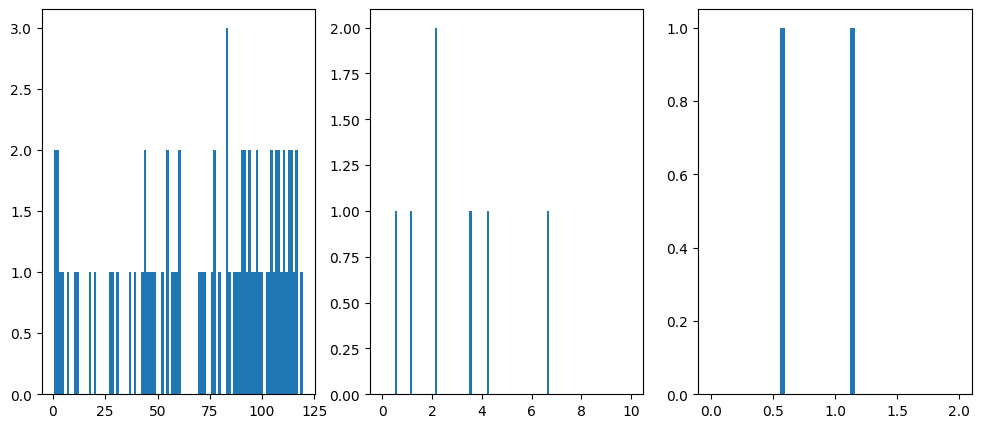

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.hist(u.Quantity(csc['seps']).to(u.arcsec), bins=100)
ax2.hist(u.Quantity(csc['seps']).to(u.arcsec), bins=100, range=(0*u.arcsec, 10*u.arcsec));
ax3.hist(u.Quantity(csc['seps']).to(u.arcsec), bins=50, range=(0*u.arcsec, 2*u.arcsec));

Now do a by-eye inspection at https://heasarc.gsfc.nasa.gov/xamin/xamin.jsp - the below prints out coordinates, as well as a blank dictionary which is to be copied into the next cell and filled out.

In [64]:
possible_match_rad = 10*u.arcsec

print('by_eye_checks = {')
for hostid in np.unique(csc[u.Quantity(csc['seps'])<possible_match_rad]['objid']):
    row = paper3_sats[paper3_sats['OBJID']==hostid][0]
    print(f"'{hostid}': '',")
    print('# {0.ra.deg:.9},{0.dec.deg:.9}'.format(row['coord']))
print('}')

by_eye_checks = {
'902122150000000345': '',
# 52.6964572,-21.0583216
'902409060000005742': '',
# 45.8588994,-15.6618661
'903499470000004210': '',
# 215.233215,3.23799031
'903576680000004128': '',
# 348.643948,4.49843422
}


The options are:
* 'a' - strong point source at glx center
* 'y' - definitely real source at glx center
* 'm' - possible source, but not obvious
* 'n' - galaxy definitly not x-ray source
* 'f' - not in footprint of heasarc viewer tool

In [80]:
by_eye_checks_csc = {
902122150000000345: 'm', # definitely an overdensity of points - 3sig, but unclear how point-source-y it is
# 52.6964572,-21.0583216
902409060000005742: 'm', #2.5 sigma.  Not compelling but possible
# 45.8588994,-15.6618661
903499470000004210: 'y', #definitely somthing there, probably point-source?  Catalog separates it into 3 sources though.
# 215.233215,3.23799031
903576680000004128: 'm',  # realy X-ray sources, but none in the core?  Probably not AGN then
# 348.643948,4.49843422
}

In [81]:
paper3_sats['in_csc'] = np.zeros(len(paper3_sats), dtype=bool)
paper3_sats['src_in_csc'] = np.zeros(len(paper3_sats), dtype=bool)
for k,v in by_eye_checks_csc.items():
    paper3_satsmsk = paper3_sats['OBJID']==k
    if v!='f':
        paper3_sats['in_csc'][paper3_satsmsk] = True
    if v=='a' or v=='y':
        paper3_sats['src_in_csc'][paper3_satsmsk] = True

In [82]:
np.sum(paper3_sats['in_csc'])/len(paper3_sats), np.sum(paper3_sats['src_in_csc'])/np.sum(paper3_sats['in_csc'])

(0.010582010582010581, 0.25)

### XMM-Newton

In [83]:
{k:(len(v), tables_dct[k].description) for k,v in xmmn_matches.items() if len(v) > 0}

{'agnsdssxm2': (1,
  'Sloan Digital Sky Survey/XMM-Newton Type1 AGN X-Ray and Radio Pr'),
 'agnsdssxmm': (1,
  'Sloan Digital Sky Survey/XMM-Newton AGN Spectral Properties Cata'),
 'sdsss82xmm': (3,
  'Sloan Digital Sky Survey Stripe 82 XMM-Newton Source Match Catal'),
 'xmmlss10ks': (4,
  'XMM-Newton Large-Scale Structure Uniform 10-ksec Exposure X-Ray'),
 'xmmlssdeep': (5,
  'XMM-Newton Large-Scale Structure Deep Full-Exposure X-Ray Source'),
 'xmmslewful': (1, 'XMM-Newton Slew Survey Full Source Catalog, v2.0'),
 'xmmssc': (92, 'XMM-Newton Serendipitous Source Catalog (4XMM-DR13 Version)'),
 'xmmstack': (42,
  'XMM-Newton Serendipitous Source Catalog from Stacked Observation'),
 'xmmstackob': (114,
  'XMM-Newton Serendipitous Source Catalog from Stacked Observation')}

In [88]:
cat = xmmn_matches['xmmlssdeep']
cat_coo = SkyCoord(ra=cat['xmmlssdeep_ra'], dec=cat['xmmlssdeep_dec'])

seps = []
for coo, row in zip(cat_coo,cat):
    hrow = paper3_sats[row['objid']==paper3_sats['OBJID']]
    assert len(hrow)==1, len(hrow)
    hrow = hrow[0]

    seps.append(hrow['coord'].separation(coo))
cat['seps'] = u.Quantity(seps)
cat['cp-coo'] = ['{0.ra.deg:.9},{0.dec.deg:.9}'.format(coo) for coo in cat_coo]

In [89]:
cat

xmmlssdeep___row,xmmlssdeep_source_number,xmmlssdeep_name,xmmlssdeep_ra,xmmlssdeep_dec,xmmlssdeep_lii,xmmlssdeep_bii,xmmlssdeep_sb_source_number,xmmlssdeep_sb_name,xmmlssdeep_extended_source_class,xmmlssdeep_sb_core_radius,xmmlssdeep_sb_extent_likelihood,xmmlssdeep_sb_detect_likelihood,xmmlssdeep_sb_off_axis,xmmlssdeep_sb_ra,xmmlssdeep_sb_dec,xmmlssdeep_sb_error_radius,xmmlssdeep_mos_sb_rate,xmmlssdeep_pn_sb_rate,xmmlssdeep_sb_flux,xmmlssdeep_sb_flux_flag,xmmlssdeep_hb_source_number,xmmlssdeep_hb_name,xmmlssdeep_hb_core_radius,xmmlssdeep_hb_extent_likelihood,xmmlssdeep_hb_detect_likelihood,xmmlssdeep_hb_off_axis,xmmlssdeep_hb_ra,xmmlssdeep_hb_dec,xmmlssdeep_hb_error_radius,xmmlssdeep_mos_hb_rate,xmmlssdeep_pn_hb_rate,xmmlssdeep_hb_flux,xmmlssdeep_hb_flux_flag,xmmlssdeep_old_source_number,xmmlssdeep___x_ra_dec,xmmlssdeep___y_ra_dec,xmmlssdeep___z_ra_dec,objid,seps,cp-coo
,,,deg,deg,deg,deg,,,,arcsec,,,arcmin,deg,deg,arcsec,ct/s/detector,ct / s,erg/s/cm^2,,,,arcsec,,,arcmin,deg,deg,arcsec,ct / s,ct / s,erg/s/cm^2,,,,,,,deg,
int32,int32,object,float64,float64,float64,float64,int32,object,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int32,float64,float64,float64,int64,float64,str17
536,34713,2XLSSd J022120.3-054425,35.33476,-5.74053,171.96901,-59.75433,24031,2XLSSB J022120.3-054425,0,0.30,0.80084,158.09200,6.20,35.33476,-5.74053,1.0,0.0021,0.0063,1e-14,0,16884,2XLSSCD J022120.5-054422,0.39,2.75435,49.60474,6.26,35.33570,-5.73964,1.5,0.0011,0.0041,2.92e-14,1,--,0.575452247949568,0.811695748378789,-0.100023609180963,902974260000007767,0.02037096660630265,"35.33476,-5.74053"
1023,29997,2XLSSd J022140.1-052751,35.41744,-5.46431,171.72103,-59.49482,19845,2XLSSB J022140.1-052751,0,0.27,0.20552,17.86321,5.54,35.41744,-5.46431,1.8,0.0004,0.0017,2.4e-15,0,13966,2XLSSCD J022140.3-052750,1.90,0.00000,13.89000,5.52,35.41793,-5.46410,2.0,0.0006,0.0007,1.01e-14,2,--,0.576895708542841,0.811248056222093,-0.0952256937004334,902988610000000459,0.024019694744505837,"35.41744,-5.46431"
1109,29992,2XLSSd J022141.4-052517,35.42280,-5.42165,171.67234,-59.45965,19840,2XLSSB J022141.4-052517,0,0.77,2.28926,27.54393,6.47,35.42280,-5.42165,1.8,0.0008,0.0024,3.8e-15,0,--,,--,--,--,--,--,--,--,--,--,--,--,--,0.577012532667403,0.811251636455325,-0.0944844934013333,902988610000000459,0.02462164352677621,"35.4228,-5.42165"
865,30016,2XLSSd J022142.9-053204,35.42902,-5.53453,171.83102,-59.53898,19864,2XLSSB J022142.9-053204,0,0.06,2.79252,59.20136,5.34,35.42902,-5.53453,1.8,0.0011,0.0024,4.6e-15,1,--,,--,--,--,--,--,--,--,--,--,--,--,--,0.576991570403708,0.811035738755662,-0.0964456227317762,902988610000001595,0.008967764481822347,"35.42902,-5.53453"
1124,29986,2XLSSd J022149.3-052456,35.45543,-5.41556,171.71160,-59.43331,19834,2XLSSB J022149.3-052455,0,--,--,--,5.42,35.45553,-5.41536,1.0,0.0102,0.0364,5.28e-14,0,13961,2XLSSCD J022149.3-052456,0.85,22.89974,138.54820,5.41,35.45543,-5.41556,1.0,0.0022,0.0106,6.73e-14,1,--,0.577480269901155,0.810931071699021,-0.0943786778248474,902988610000002815,0.033166441162889936,"35.45543,-5.41556"


None of these are actual sat matches, coincidental neighbors.

In [92]:
cat = xmmn_matches['xmmssc']
cat_coo = SkyCoord(ra=cat['xmmssc_ra'], dec=cat['xmmssc_dec'])

seps = []
for coo, row in zip(cat_coo,cat):
    hrow = paper3_sats[row['objid']==paper3_sats['OBJID']]
    assert len(hrow)==1, len(hrow)
    hrow = hrow[0]

    seps.append(hrow['coord'].separation(coo))
cat['seps'] = u.Quantity(seps)
cat['cp-coo'] = ['{0.ra.deg:.9},{0.dec.deg:.9}'.format(coo) for coo in cat_coo]

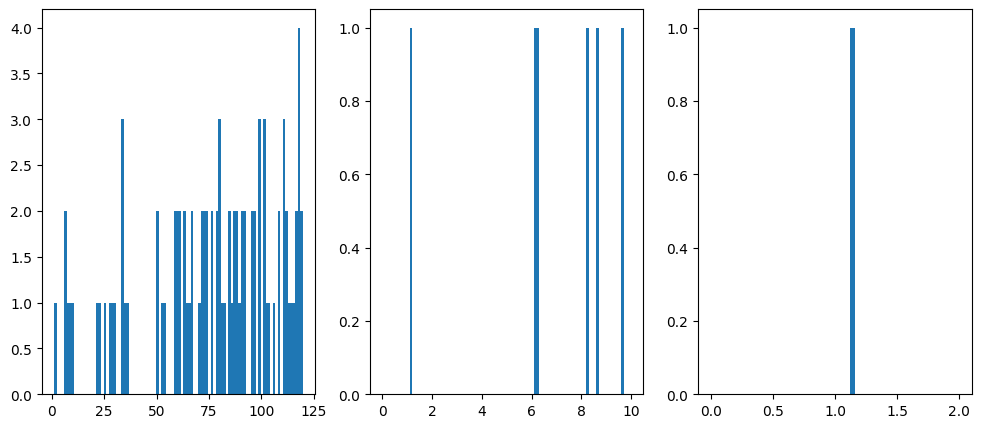

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.hist(u.Quantity(cat['seps']).to(u.arcsec), bins=100)
ax2.hist(u.Quantity(cat['seps']).to(u.arcsec), bins=100, range=(0*u.arcsec, 10*u.arcsec));
ax3.hist(u.Quantity(cat['seps']).to(u.arcsec), bins=50, range=(0*u.arcsec, 2*u.arcsec));

In [95]:
possible_match_rad = 40*u.arcsec

print('by_eye_checks = {')
for hostid in np.unique(cat[u.Quantity(cat['seps'])<possible_match_rad]['objid']):
    row = paper3_sats[paper3_sats['OBJID']==hostid][0]
    print(f"'{hostid}': '',")
    print('# {0.ra.deg:.9},{0.dec.deg:.9}'.format(row['coord']))
print('}')

by_eye_checks = {
'900800500000006536': '',
# 318.017097,-49.4632837
'900809930000006835': '',
# 317.926824,-49.1874741
'902409060000005742': '',
# 45.8588994,-15.6618661
'902409080000006997': '',
# 46.40637,-15.8116106
'902422950000000287': '',
# 45.851008,-15.6226291
'902422950000002380': '',
# 45.9306892,-15.4845559
'902422980000000214': '',
# 46.6221382,-15.5689512
'902616890000002817': '',
# 354.779882,-12.2240098
'902988610000001595': '',
# 35.4379915,-5.53535544
'903332240000007712': '',
# 354.19548,0.330583147
'903499470000004210': '',
# 215.233215,3.23799031
'903699000000000343': '',
# 179.010299,6.67790873
'904251140000004290': '',
# 234.133155,16.4400328
'915478090000003987': '',
# 138.679741,40.8801642
}


The options are:
* 'a' - strong point source at glx center
* 'y' - definitely real source at glx center
* 'm' - possible source, but not obvious
* 'n' - galaxy definitly not x-ray source
* 'f' - not in footprint of heasarc viewer tool

In [105]:
by_eye_checks_xmmssc = {
900800500000006536: 'n',  # very close real source but it's a nearby starr
# 318.017097,-49.4632837
900809930000006835: 'n',  # not the sat
# 317.926824,-49.1874741
902409060000005742: 'n',  # nearby source in XMM, but not in equivalent Chandra image?  Or marginal?
# 45.8588994,-15.6618661
902409080000006997: 'n', # nearby source, not associated?
# 46.40637,-15.8116106
902422950000000287: 'n',  # in outskirts, not compelling (~1-2 sig detection)
# 45.851008,-15.6226291
902422950000002380: 'n', #non-match
# 45.9306892,-15.4845559
902422980000000214: 'm',  # there's a real point-like source here.  Offset, but maybe this is an astrometry problem?
# 46.6221382,-15.5689512
902616890000002817: 'y',  # this one is weak but very real and in the sat center
# 354.779882,-12.2240098
902988610000001595: 'n', # detector artifact
# 35.4379915,-5.53535544
903332240000007712: 'n',
# 354.19548,0.330583147
903499470000004210: 'y',  # strong in EPIC but not PN? Also in Chandra as a y
# 215.233215,3.23799031
903699000000000343: 'n',  # nearby star-like
# 179.010299,6.67790873
904251140000004290: 'y',  # very strong in PN? Also in Chandra but not as point-like?  Mis-aligned with galaxy though? jet?
# 234.133155,16.4400328
915478090000003987: 'm',  #weak detection, also in Chandra but offset from core
# 138.679741,40.8801642
}

In [106]:
paper3_sats['in_xmmssc'] = np.zeros(len(paper3_sats), dtype=bool)
paper3_sats['src_in_xmmssc'] = np.zeros(len(paper3_sats), dtype=bool)
for k,v in by_eye_checks_xmmssc.items():
    paper3_satsmsk = paper3_sats['OBJID']==k
    if v!='f':
        paper3_sats['in_xmmssc'][paper3_satsmsk] = True
    if v=='a' or v=='y':
        paper3_sats['src_in_xmmssc'][paper3_satsmsk] = True

In [107]:
np.sum(paper3_sats['in_xmmssc'])/len(paper3_sats), np.sum(paper3_sats['src_in_xmmssc'])/np.sum(paper3_sats['in_xmmssc'])

(0.037037037037037035, 0.21428571428571427)

# Summary fractions

In [110]:
np.sum(paper3_sats['in_xmmssc']|paper3_sats['in_csc'])/len(paper3_sats), np.sum(paper3_sats['src_in_xmmssc']|paper3_sats['src_in_csc'])/np.sum(paper3_sats['in_xmmssc']|paper3_sats['in_csc'])

(0.042328042328042326, 0.1875)

In [109]:
np.sum(paper3_sats['src_in_xmmssc']|paper3_sats['src_in_csc'])

3

Compare to Li et al. 2016 (https://arxiv.org/pdf/1710.07355.pdf)

In [112]:
liscs = [SkyCoord.from_name(glxnm) for glxnm in ['UGC 12591', 'NGC 669', 'ESO142-G019', 'NGC 5908', 'UGCA 145', 'NGC 550']]    
liscs

[<SkyCoord (ICRS): (ra, dec) in deg
     (351.34065625, 28.49515139)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (26.81718005, 35.56328211)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (293.32882845, -58.11422442)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (229.18003277, 55.40926144)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (131.8207542, -20.0356611)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (21.67730184, 2.02231)>]

In [ ]:
spec.wcs.

In [119]:
for lisc in liscs:
    seps = paper3_hosts['coord'].separation(lisc)
    if np.any(seps<1*u.deg):
        msk = seps<1*u.deg
        print(paper3_hosts[msk], seps[msk])

No matches to Li+ 16